In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np

from keras import Model
from keras.layers import Embedding, Input, Flatten, Dot, Add
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

## Train Model

In [6]:
ratings = pd.read_csv("data/scores.csv", index_col=0)

# Create a dictionary of indexes for the users and movies maping every ID to a given index.
u_unique = ratings.user_id.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movie_id.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

# Replace the users and movies ids with the new index value.
ratings.user_id = ratings.user_id.apply(lambda x: user2Idx[x])
ratings.movie_id = ratings.movie_id.apply(lambda x: movie2Idx[x])

n_users = int(ratings.user_id.nunique())
n_movies = int(ratings.movie_id.nunique())

In [7]:
def build_keras_model(users_number, movies_number, latent_factors=5, add_bias=False, loss="mean_squared_error", learning_rate=0.001, metrics=["root_mean_squared_error"]):
    movie_input = Input(shape=[1], name='Item')
    user_input = Input(shape=[1],name='User')
    
    # Movie Embedding Layer
    movie_embedding = Embedding(
        movies_number + 1, 
        latent_factors, 
        embeddings_regularizer=l2(0.001),
        name='Movie-Embedding'
    )(movie_input)
    
    movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
    
    # User Embedding Layer
    user_embedding = Embedding(
        users_number + 1, 
        latent_factors, 
        name='User-Embedding'
    )(user_input)

    user_vec = Flatten(name='FlattenUsers')(user_embedding)
    
    prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
    
    if add_bias:
        # Movie Bias Embedding Layer
        movie_bias_embedding = Embedding(
            movies_number + 1, 
            1, 
            embeddings_regularizer=l2(0.001),
            name='Movie-Bias-Embedding'
        )(movie_input)
        movie_bias = Flatten(name='FlattenMoviesBias')(movie_bias_embedding)
        
        # User Bias Embedding Layer
        user_bias_embedding = Embedding(
            users_number + 1, 
            1, 
            name='User-Bias-Embedding'
        )(user_input)
        user_bias = Flatten(name='FlattenUserBias')(user_bias_embedding)
        prod = Add()([prod, user_bias, movie_bias])

    model = Model([user_input, movie_input], prod)
    model.compile(Adam(learning_rate=learning_rate), loss, metrics=metrics)
    return model

In [20]:
    # split dataset
eval_size = 0.2
ratings_train, ratings_val = train_test_split(ratings, test_size=eval_size)

best_lf = 0
best_mse = float('inf')
epochs=100
latent_factor = 2
model = build_keras_model(n_users, n_movies)
model.summary()

model = build_keras_model(n_users, n_movies, latent_factors=latent_factor, add_bias=True)
history = model.fit(
    [ratings_train.user_id, ratings_train.movie_id], 
    ratings_train.rating, 
    batch_size=320,
    validation_data=([ratings_val.user_id, ratings_val.movie_id], ratings_val.rating), 
    epochs=epochs,
    verbose=1
)
metrics_train = model.evaluate([ratings_train.user_id, ratings_train.movie_id], ratings_train.rating)
metrics_val = model.evaluate([ratings_val.user_id, ratings_val.movie_id], ratings_val.rating)

print(f"RMSE: {metrics_val[1]} for latent_factor={latent_factor}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Movie-Embedding (Embedding)   │ (None, 1, 5)              │           8,415 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User-Embedding (Embedding)    │ (None, 1, 5)              │           4,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenMovies (Flatten)       │ (None, 5)                 │               0 │ Movie-Embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUsers (Flatten)        │ (None, 5)                 │               0 │ User-Embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ DotProduct (Dot)              │ (None, 1)                 │               0 │ FlattenMovies[0][0],       │
│                               │                           │                 │ FlattenUsers[0][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 13,135 (51.31 KB)

 Trainable params: 13,135 (51.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.1756 - root_mean_squared_error: 3.6291 - val_loss: 11.6260 - val_root_mean_squared_error: 3.4067
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.9253 - root_mean_squared_error: 3.2980 - val_loss: 8.8416 - val_root_mean_squared_error: 2.9480
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1460 - root_mean_squared_error: 2.8181 - val_loss: 6.2544 - val_root_mean_squared_error: 2.4299
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7309 - root_mean_squared_error: 2.3075 - val_loss: 4.5013 - val_root_mean_squared_error: 1.9875
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1704 - root_mean_squared_error: 1.8901 - val_loss: 3.5366 - val_root_mean_squared_error: 1.6810
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3450 - root_mean_squared_error: 1.6135 - val_loss: 3.0450 - val_root_mean_squared_error: 1.4936
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s

In [9]:
layers = {layer.name: layer for layer in model.layers}
layers

{'Item': <InputLayer name=Item, built=True>,
 'User': <InputLayer name=User, built=True>,
 'Movie-Embedding': <Embedding name=Movie-Embedding, built=True>,
 'User-Embedding': <Embedding name=User-Embedding, built=True>,
 'FlattenMovies': <Flatten name=FlattenMovies, built=True>,
 'FlattenUsers': <Flatten name=FlattenUsers, built=True>,
 'User-Bias-Embedding': <Embedding name=User-Bias-Embedding, built=True>,
 'Movie-Bias-Embedding': <Embedding name=Movie-Bias-Embedding, built=True>,
 'DotProduct': <Dot name=DotProduct, built=True>,
 'FlattenUserBias': <Flatten name=FlattenUserBias, built=True>,
 'FlattenMoviesBias': <Flatten name=FlattenMoviesBias, built=True>,
 'add': <Add name=add, built=True>}

## K-Means

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [11]:
movies = pd.read_csv("data/peliculas.csv")
users = pd.read_csv("data/usuarios.csv")

In [12]:
users['userIdx'] = users['id'].apply(lambda x: user2Idx[x])
movies['movieIdx'] = movies['id'].apply(lambda x: movie2Idx[x])

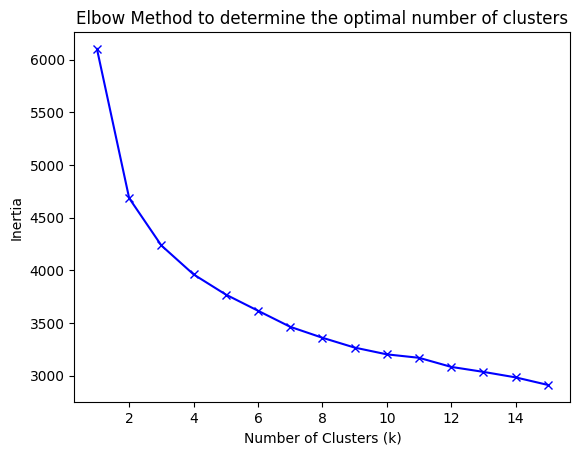

In [21]:
inertias = []
user_embeddings = layers["User-Embedding"].get_weights()[0] # Substitua pelos seus embeddings
k_values = range(1, 16)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(user_embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to determine the optimal number of clusters')
plt.show()

In [22]:
from sklearn.manifold import TSNE

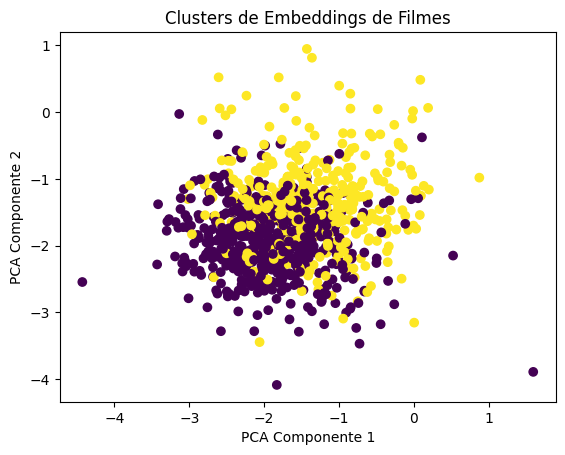

In [25]:
# Predicting clusters
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(user_embeddings)

# Dimensionality reduction using TSNE
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(user_embeddings)
reduced_embeddings = user_embeddings

# Plot clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters)
plt.title('Clusters de Embeddings de Filmes')
plt.xlabel('TSNE Componente 1')
plt.ylabel('TSNE Componente 2')
plt.show()

In [16]:
ratings["cluster"] = clusters[ratings.user_id]

In [17]:
users["cluster"] = clusters[users.userIdx]